In [80]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
from theano import config

from deepensemble.utils import jacobs
from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.layers.recurrent import RecurrentLayer
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *
from deepensemble.metrics import *
from deepensemble.utils import *

N = 1000

X, y = friendman(sample_len=N, seed=42)
y = np.array(y[:, np.newaxis], dtype=config.floatX)
X = np.array(X, dtype=config.floatX)
t = np.arange(N)

# Added Noise
s_noise = 0.0
nu = np.random.randn(N, 1) * s_noise
# nu[np.random.rand(N,1) > 0.95] += 0.2

z = y

n_train = int(N * 0.5)
i_test = N - n_train

y_train = z[0:n_train]
y_test = z[i_test:N]
X_train = X[0:n_train]
X_test = X[i_test:N]
t_train = t[0:n_train]
t_test = t[i_test:N]

fx_train = y[0:n_train]
fx_test = y[i_test:N]

<IPython.core.display.Javascript object>


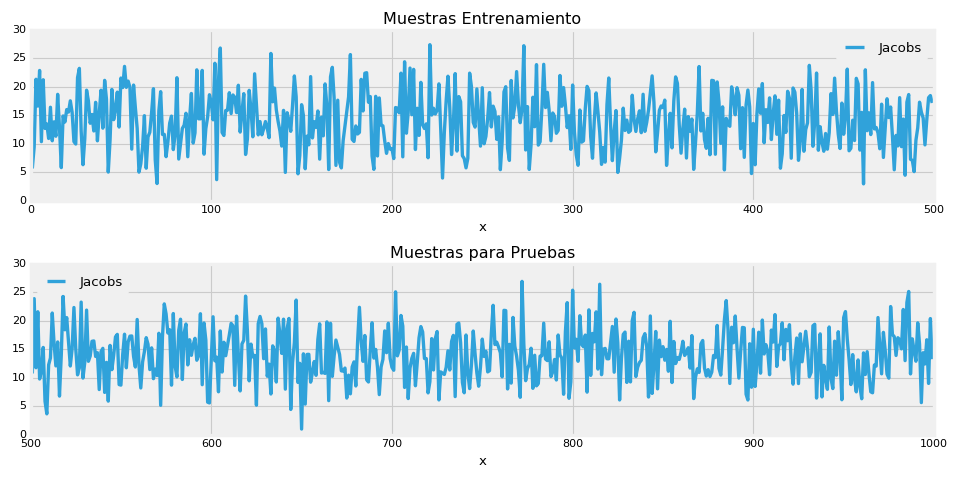

In [2]:
from matplotlib.pyplot import *
%matplotlib notebook

import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

fig = plt.figure(figsize=(12, 6), dpi=80)
ConfigPlot().set_size_font(10)

ax = plt.subplot(211)
ax.plot(t_train, fx_train, '-', lw=3, label='Jacobs')
plt.title('Muestras Entrenamiento')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

ax = plt.subplot(212)
ax.plot(t_test, fx_test, '-', lw=3, label='Jacobs')
plt.title('Muestras para Pruebas')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

In [81]:
n_neurons = 15
n_models = 4
lr = 0.1
batch_size = 40
max_epoch = 500

n_ensemble_models = 3

fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.linear

n_features = X_train.shape[1]

n_output = y_train.shape[1]
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

s = ITLFunctions.silverman(np.array(y_train)).eval()
print('Silverman: %0.4g' % s)

args_train_default = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True}

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 1.498


In [32]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble',
                                  n_input=n_features, n_output=n_output,
                                  n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                                  fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                  cost=mse, name_cost="MSE",
                                  params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

# Compile
ensemble.compile(fast=True)

# training
metrics = ensemble.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Comienza la compilación Ensamble  - elapsed: 1.26 [s]
Ensamble - fold: 1, epoch:[####################] 500/500 elapsed: 1.74[s] - left: 0.00[s] | score: 2.7272 / 5.70079
FINISHED!


In [30]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL',
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        lamb=0.8, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)

# Compile
ensembleNCL.compile(fast=True)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Comienza la compilación Ensamble NCL  - elapsed: 3.30 [s]
Ensamble NCL - fold: 1, epoch:[####################] 500/500 elapsed: 2.77[s] - left: 0.00[s] | score: 1.3049 / 3.71134
FINISHED!


In [75]:
# Create MLP
mlp = get_mlp_model("MLP (%d neuronas)" % (n_neurons_model * n_ensemble_models),
                           n_input=n_features, n_output=n_output,
                           n_neurons=n_neurons_model,
                           fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                           cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)

# Compile
mlp.compile(fast=True)
                      
# training
metrics = mlp.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Comienza la compilación MLP (24 neuronas)  - elapsed: 0.42 [s]
MLP (24 neuronas) - fold: 1, epoch:[####################] 500/500 elapsed: 0.95[s] - left: 0.00[s] | score: 4.3462 / 7.64250
FINISHED!


In [116]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIP',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=0.1, lamb=0.1, s=s,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.1*lr,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -5*lr})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)

# Compile
ensembleCIP.compile(fast=False)
                      
# training
metrics = ensembleCIP.fit(X_train, y_train, **args_train_cip)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIP  - elapsed: 21.30 [s]
Ensamble CIP - fold: 1, epoch:[####################] 500/500 elapsed: 12.96[s] - left: 0.00[s] | score: 2.3543 / 4.7684
FINISHED!


<IPython.core.display.Javascript object>


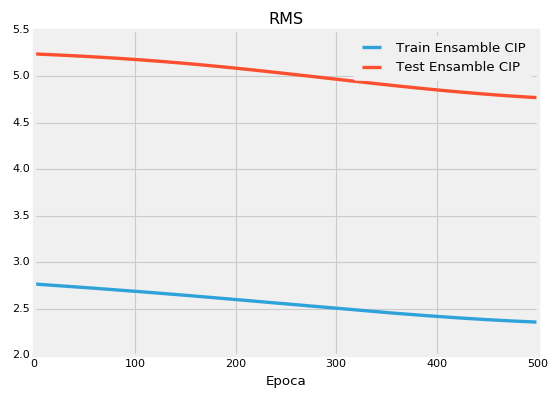

<IPython.core.display.Javascript object>


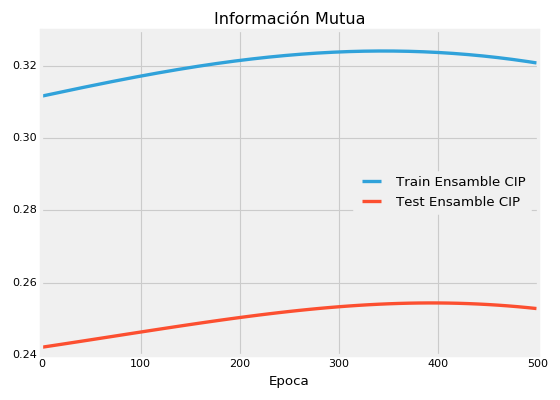

<IPython.core.display.Javascript object>


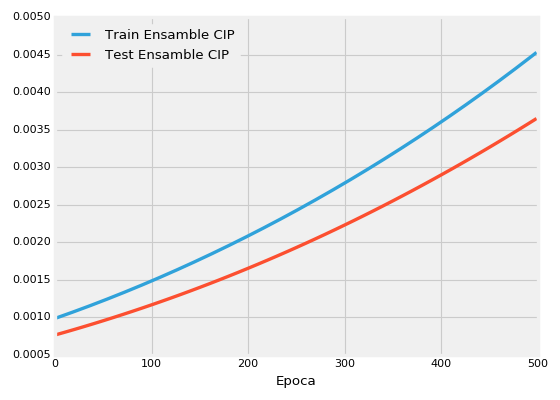

In [117]:
ConfigPlot().set_size_font(10)
ConfigPlot().set_dpi(80)
ConfigPlot().set_hold(False)
ConfigPlot().set_fig_size((7, 5))

metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')
metrics_ensembleCIP.plot_cost(max_epoch=max_epoch, title='')

plt.show()

<IPython.core.display.Javascript object>


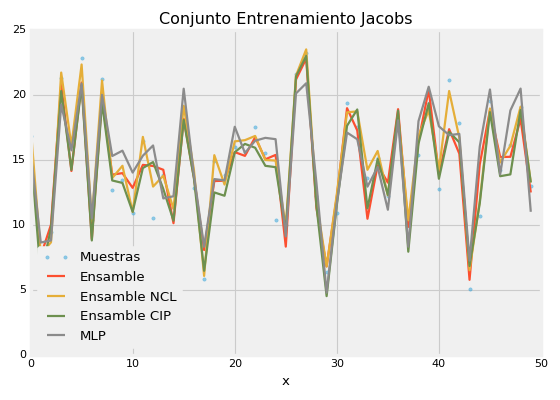

<IPython.core.display.Javascript object>


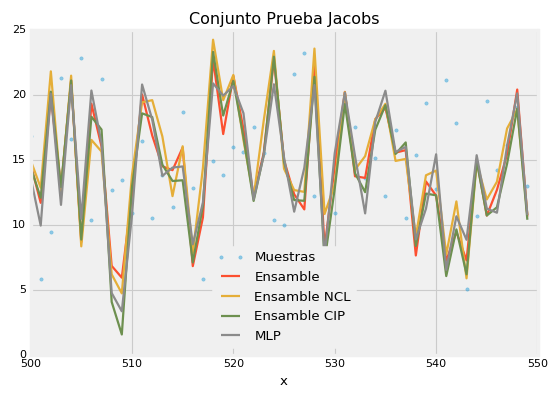

In [118]:
plt.close()

fig = plt.figure(figsize=(7, 5), dpi=80)

nm = 50

plt.plot(t_train[0:nm], z[0:nm], '.', alpha=0.5,  label='Muestras')
plt.plot(t_train[0:nm], ensemble.predict(X_train[0:nm]), lw=2, label='Ensamble')
plt.plot(t_train[0:nm], ensembleNCL.predict(X_train[0:nm]), lw=2, label='Ensamble NCL')
plt.plot(t_train[0:nm], ensembleCIP.predict(X_train[0:nm]), lw=2, label='Ensamble CIP')
plt.plot(t_train[0:nm], mlp.predict(X_train[0:nm]), lw=2, label='MLP')
plt.title('Conjunto Entrenamiento Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

fig = plt.figure(figsize=(7, 5), dpi=80)

plt.plot(t_test[0:nm], z[0:nm], '.', alpha=0.5, label='Muestras')
plt.plot(t_test[0:nm], ensemble.predict(X_test[0:nm]), lw=2, label='Ensamble')
plt.plot(t_test[0:nm], ensembleNCL.predict(X_test[0:nm]), lw=2, label='Ensamble NCL')
plt.plot(t_test[0:nm], ensembleCIP.predict(X_test[0:nm]), lw=2, label='Ensamble CIP')
plt.plot(t_test[0:nm], mlp.predict(X_test[0:nm]), lw=2, label='MLP')
plt.title('Conjunto Prueba Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


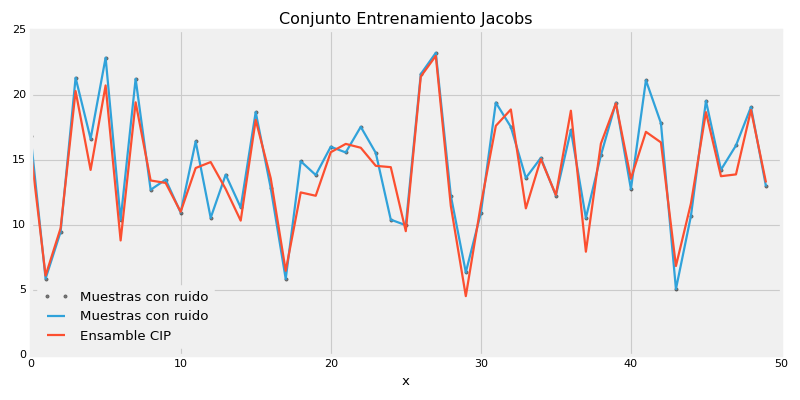

<IPython.core.display.Javascript object>


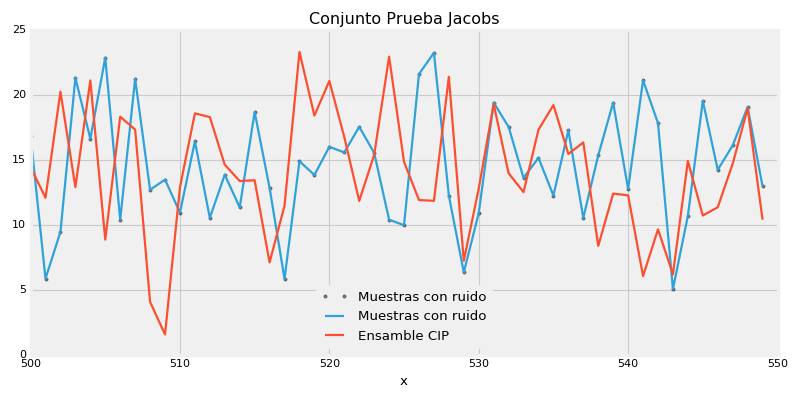

In [119]:
fig = plt.figure(figsize=(10, 5), dpi=80)

nm = 50

plt.plot(t_train[0:nm], z[0:nm], 'k.', alpha=0.5,  label='Muestras con ruido')
plt.plot(t_train[0:nm], y[0:nm], lw=2, label='Muestras con ruido')
plt.plot(t_train[0:nm], ensembleCIP.predict(X_train[0:nm]), lw=2, label='Ensamble CIP')
plt.title('Conjunto Entrenamiento Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

fig = plt.figure(figsize=(10, 5), dpi=80)

plt.plot(t_test[0:nm], z[0:nm], 'k.', alpha=0.5, label='Muestras con ruido')
plt.plot(t_test[0:nm], y[0:nm], lw=2,label='Muestras con ruido')
plt.plot(t_test[0:nm], ensembleCIP.predict(X_test[0:nm]), lw=2, label='Ensamble CIP')
plt.title('Conjunto Prueba Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


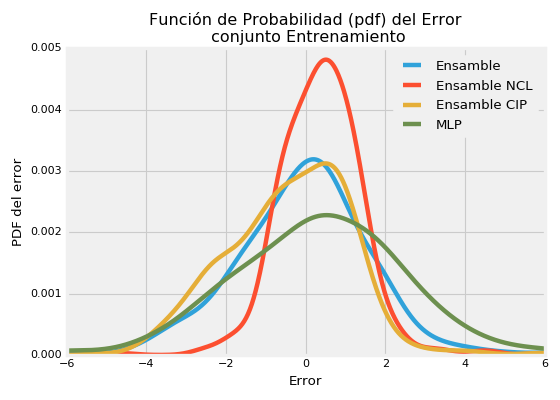

In [120]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-6, xmax=6):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=s)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(7, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_train), y_train, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_train), y_train, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleCIP.predict(X_train), y_train, 'Ensamble CIP', ax, fig)
plot_pdf_error(mlp.predict(X_train), y_train, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento")
plt.legend()

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


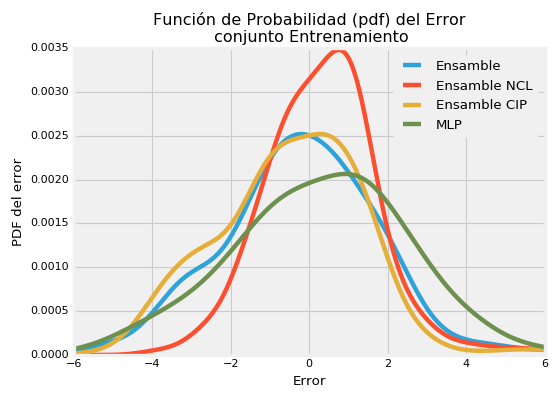

In [121]:
fig = plt.figure(figsize=(7, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_test), y_test, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_test), y_test, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleCIP.predict(X_test), y_test, 'Ensamble CIP', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento")
plt.legend()

plt.tight_layout()

plt.show()

In [122]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleCIP = ensembleCIP.score(X_test, y_test)
score_train_ensembleCIP = ensembleCIP.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble: 2.980586 / 4.202040
Ensamble NCL: 1.369829 / 2.306016
Ensamble CIP: 2.652161 / 3.787522
MLP: 5.086937 / 5.484894


In [123]:
def get_ensemble_cip_cs(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIP CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lr=0.1*lr,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.1}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_ed(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIP ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lr=0.1*lr,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.5}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [124]:
parameters = [n for n in np.linspace(-1, 1, 21)]

score_cs = []
diversity_cs = []
for p in parameters:
    model_cs = get_ensemble_cip_cs(p, s)
    metric = model_cs.fit(X_train, y_train, **args_train_cip)
    score_cs.append(model_cs.score(X_test, y_test))
    metric.append_prediction(X_test, y_test, append_last_pred=True)
    diversity_cs.append( metric.get_diversity(metric=ambiguity) )

Comienza la compilación Ensamble CIP CS  - elapsed: 23.46 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 14.28[s] - left: 0.00[s] | score: 2340.7051 / 2661.2971
Comienza la compilación Ensamble CIP CS  - elapsed: 19.40 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 14.60[s] - left: 0.00[s] | score: 2032.1128 / 2331.9216
Comienza la compilación Ensamble CIP CS  - elapsed: 18.98 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 14.40[s] - left: 0.00[s] | score: 2129.2225 / 2418.2713
Comienza la compilación Ensamble CIP CS  - elapsed: 14.34 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 12.50[s] - left: 0.00[s] | score: 1818.7714 / 1989.0188
Comienza la compilación Ensamble CIP CS  - elapsed: 18.48 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 12.76[s] - left: 0.00[s] | score: 1708.4162 / 1969.3028
Comienza la compilación Ensamble CIP CS  - el

In [125]:
score_ed = []
diversity_ed = []
for p in parameters:
    model_ed = get_ensemble_cip_ed(p, s)
    metric = model_ed.fit(X_train, y_train, **args_train_cip)
    score_ed.append(model_ed.score(X_test, y_test))
    metric.append_prediction(X_test, y_test, append_last_pred=True)
    diversity_ed.append( metric.get_diversity(metric=ambiguity) )

Comienza la compilación Ensamble CIP ED  - elapsed: 16.96 [s]
Ensamble CIP ED - fold: 1, epoch:[####################] 500/500 elapsed: 10.33[s] - left: 0.00[s] | score: 2.8627 / 5.2720
Comienza la compilación Ensamble CIP ED  - elapsed: 13.86 [s]
Ensamble CIP ED - fold: 1, epoch:[####################] 500/500 elapsed: 10.02[s] - left: 0.00[s] | score: 2.8037 / 5.7474
Comienza la compilación Ensamble CIP ED  - elapsed: 17.44 [s]
Ensamble CIP ED - fold: 1, epoch:[####################] 500/500 elapsed: 9.87[s] - left: 0.00[s] | score: 4.2598 / 6.7524
Comienza la compilación Ensamble CIP ED  - elapsed: 17.05 [s]
Ensamble CIP ED - fold: 1, epoch:[####################] 500/500 elapsed: 9.83[s] - left: 0.00[s] | score: 2.7956 / 4.8292
Comienza la compilación Ensamble CIP ED  - elapsed: 17.18 [s]
Ensamble CIP ED - fold: 1, epoch:[####################] 500/500 elapsed: 9.65[s] - left: 0.00[s] | score: 2.4160 / 4.3549
Comienza la compilación Ensamble CIP ED  - elapsed: 13.41 [s]
Ensamble CIP ED 

<IPython.core.display.Javascript object>


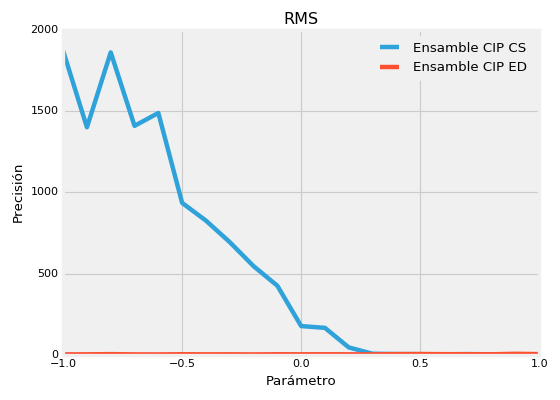

<IPython.core.display.Javascript object>


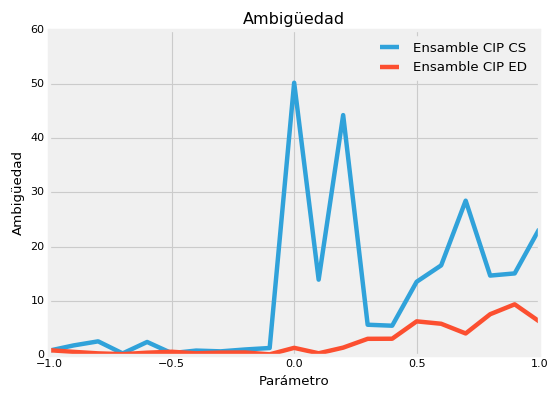

In [126]:
score_cs = np.array(score_cs)
diversity_cs = np.array(diversity_cs)
score_ed = np.array(score_ed)
diversity_ed = np.array(diversity_ed)

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, score_cs, label='Ensamble CIP CS')
plt.plot(parameters, score_ed, label='Ensamble CIP ED')
plt.legend()
plt.title('RMS')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')

plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(parameters, diversity_cs[:, 0], label='Ensamble CIP CS')
plt.plot(parameters, diversity_ed[:, 0], label='Ensamble CIP ED')
plt.legend()
plt.title('Ambigüedad')
plt.xlabel('Parámetro')
plt.ylabel('Ambigüedad')

plt.tight_layout()

plt.show()

In [127]:
def get_ensemble_cip_s_cs(s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIP CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.1, lamb=0.1, s=s_sigma,
                                    lr=0.1*lr,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.1}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_s_ed(s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIP ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=0.1, lamb=0.1, s=s_sigma,
                                    lr=0.1*lr,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.5}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [128]:
ns = np.array([0.01, 0.1, 0.5, 1, 2, 10, 100])

sss = s * ns

score_s_cs = []
diversity_s_cs = []
for ss in sss:
    model_cs = get_ensemble_cip_s_cs(ss)
    metric = model_cs.fit(X_train, y_train, **args_train_cip)
    score_s_cs.append(model_cs.score(X_test, y_test))
    metric.append_prediction(X_test, y_test, append_last_pred=True)
    diversity_s_cs.append( metric.get_diversity(metric=ambiguity) )

Comienza la compilación Ensamble CIP CS  - elapsed: 25.70 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 12.13[s] - left: 0.00[s] | score: 76.2755 / 61.332988
Comienza la compilación Ensamble CIP CS  - elapsed: 21.89 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 14.73[s] - left: 0.00[s] | score: 97.4762 / 78.964746
Comienza la compilación Ensamble CIP CS  - elapsed: 23.96 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 12.98[s] - left: 0.00[s] | score: 295.6746 / 246.4966
Comienza la compilación Ensamble CIP CS  - elapsed: 24.03 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 13.55[s] - left: 0.00[s] | score: 169.0707 / 138.3431
Comienza la compilación Ensamble CIP CS  - elapsed: 23.08 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 13.39[s] - left: 0.00[s] | score: 77.5796 / 67.6335
Comienza la compilación Ensamble CIP CS  - elapsed: 21.86

In [129]:
score_s_ed = []
diversity_s_ed = []
for ss in sss:
    model_ed = get_ensemble_cip_s_ed(ss)
    metric = model_cs.fit(X_train, y_train, **args_train_cip)
    score_s_ed.append(model_ed.score(X_test, y_test))
    metric.append_prediction(X_test, y_test, append_last_pred=True)
    diversity_s_ed.append( metric.get_diversity(metric=ambiguity) )

Comienza la compilación Ensamble CIP ED  - elapsed: 18.40 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 12.10[s] - left: 0.00[s] | score: 2.5804 / 5.2182
Comienza la compilación Ensamble CIP ED  - elapsed: 17.83 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 12.02[s] - left: 0.00[s] | score: 2.5547 / 4.8620
Comienza la compilación Ensamble CIP ED  - elapsed: 19.13 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 13.27[s] - left: 0.00[s] | score: 2.6840 / 5.2103
Comienza la compilación Ensamble CIP ED  - elapsed: 21.81 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 13.61[s] - left: 0.00[s] | score: 2.4983 / 4.8732
Comienza la compilación Ensamble CIP ED  - elapsed: 19.85 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 13.44[s] - left: 0.00[s] | score: 2.5098 / 4.7878
Comienza la compilación Ensamble CIP ED  - elapsed: 21.66 [s]
Ensamble CIP 

<IPython.core.display.Javascript object>


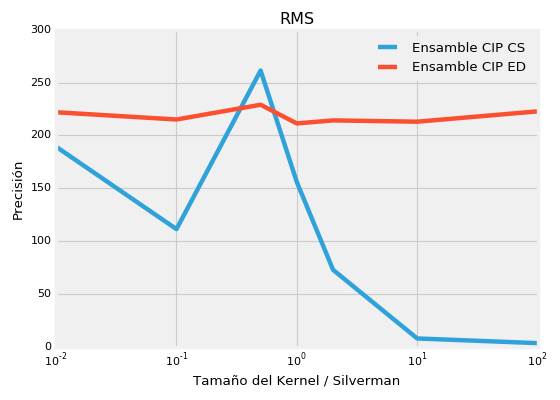

<IPython.core.display.Javascript object>


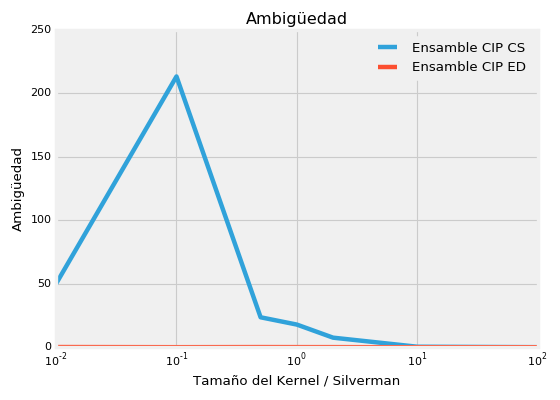

In [130]:
score_s_cs = np.array(score_s_cs)
diversity_s_cs = np.array(diversity_s_cs)
score_s_ed = np.array(score_s_ed)
diversity_s_ed = np.array(diversity_s_ed)

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(ns, score_s_cs, label='Ensamble CIP CS')
plt.plot(ns, score_s_ed, label='Ensamble CIP ED')
plt.legend()
plt.title('RMS')
plt.xlabel('Tamaño del Kernel / Silverman')
plt.ylabel('Precisión')
plt.xscale('log')

plt.tight_layout()

f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(ns, diversity_s_cs[:, 0], label='Ensamble CIP CS')
plt.plot(ns, diversity_s_ed[:, 0], label='Ensamble CIP ED')
plt.legend()
plt.title('Ambigüedad')
plt.xlabel('Tamaño del Kernel / Silverman')
plt.ylabel('Ambigüedad')
plt.xscale('log')

plt.tight_layout()

plt.show()

In [131]:
model_cs = get_ensemble_cip_cs(0.5, s)
model_cs.fit(X_train, y_train, **args_train_cip)

Comienza la compilación Ensamble CIP CS  - elapsed: 20.47 [s]
Ensamble CIP CS - fold: 1, epoch:[####################] 500/500 elapsed: 13.49[s] - left: 0.00[s] | score: 9.2759 / 8.0908


In [132]:
model_ed = get_ensemble_cip_ed(0.5, s)
model_ed.fit(X_train, y_train, **args_train_cip)

Comienza la compilación Ensamble CIP ED  - elapsed: 20.07 [s]
Ensamble CIP ED - fold: 1, epoch:[####################] 500/500 elapsed: 10.47[s] - left: 0.00[s] | score: 2.8334 / 4.6695


In [133]:
noise = [n for n in np.linspace(0.01, 1, 10)]
score_snr_cs = []
score_snr_ed = []
score_snr_ncl = []
score_snr_en = []
score_snr_mlp = []
SNR = []
N = X_test.shape[0]
F = X_test.shape[1]
mu = 0.2

for n in noise:
    ne = np.random.randn(N, F) * n + mu
    z = X_test + ne
    score_snr_cs.append(model_cs.score(z, y_test))
    score_snr_ed.append(model_ed.score(z, y_test))
    score_snr_ncl.append(ensembleNCL.score(z, y_test))
    score_snr_en.append(ensemble.score(z, y_test))
    score_snr_mlp.append(mlp.score(z, y_test))
    SNR.append(np.var(X_test) / np.var(ne))

<IPython.core.display.Javascript object>


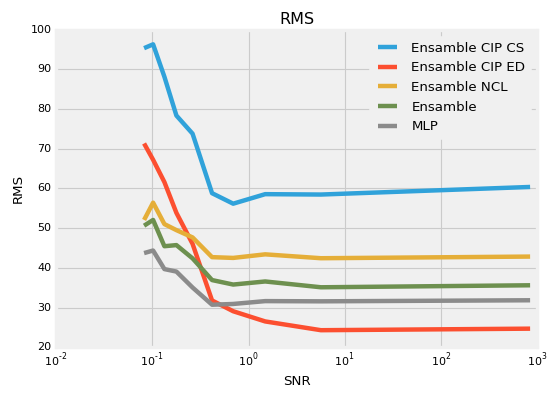

In [134]:
f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(SNR, score_snr_cs, label='Ensamble CIP CS')
plt.plot(SNR, score_snr_ed, label='Ensamble CIP ED')
plt.plot(SNR, score_snr_ncl, label='Ensamble NCL')
plt.plot(SNR, score_snr_en, label='Ensamble')
plt.plot(SNR, score_snr_mlp, label='MLP')
plt.xscale('log')
plt.legend(loc='best')
plt.title('RMS')
plt.xlabel('SNR')
plt.ylabel('RMS')
plt.tight_layout()

plt.show()